In [1]:
import sys
import os
import torch
import random
import torchvision
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dataset import DataAugmentation, DatasetManager
from model import Model
from util import set_seed
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
from pytorch_grad_cam import (
    GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus,
    AblationCAM, XGradCAM, EigenCAM, EigenGradCAM,
    LayerCAM, FullGrad, GradCAMElementWise, KPCA_CAM
)
from PIL import Image
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CLASSES = ('2s1', 'bmp2', 'btr70', 'm1', 'm2', 'm35', 'm60', 'm548', 't72', 'zsu23')
BATCH_SIZE = 10

CLASSES = ('2s1', 'bmp2', 'btr70', 'm1', 'm2', 'm35', 'm60', 'm548', 't72', 'zsu23')
TRAIN_DIR = 'dataset/synth'
TEST_DIR = 'dataset/real'

val_split = 0.1

In [3]:
def show_augmentations(color_jitter=False,
                  gaussian_noise=False,
                  random_erasing=False,
                  jitter_params=None,
                  noise_sigma=None,
                  erasing_params=None):
    set_seed()

    augmentation_module = DataAugmentation(
            color_jitter=color_jitter,
            gaussian_noise=gaussian_noise,
            random_erasing=random_erasing,
            jitter_params=jitter_params,
            noise_sigma=noise_sigma,
            erasing_params=erasing_params
        )
    
    data_loader_builder = DatasetManager(
            batch_size=BATCH_SIZE,
            train_dir=TRAIN_DIR,
            test_dir=TEST_DIR,
            val_split=val_split,
            augmentation=augmentation_module
        )
    
    synthetic_data, measured_data, _ = data_loader_builder.setup()
    return synthetic_data, measured_data

def imshow(img, title):
    plt.rcParams["savefig.bbox"] = 'tight'
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    figure = plt.figure(figsize=(16, 16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

## No Augmentations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


Measured


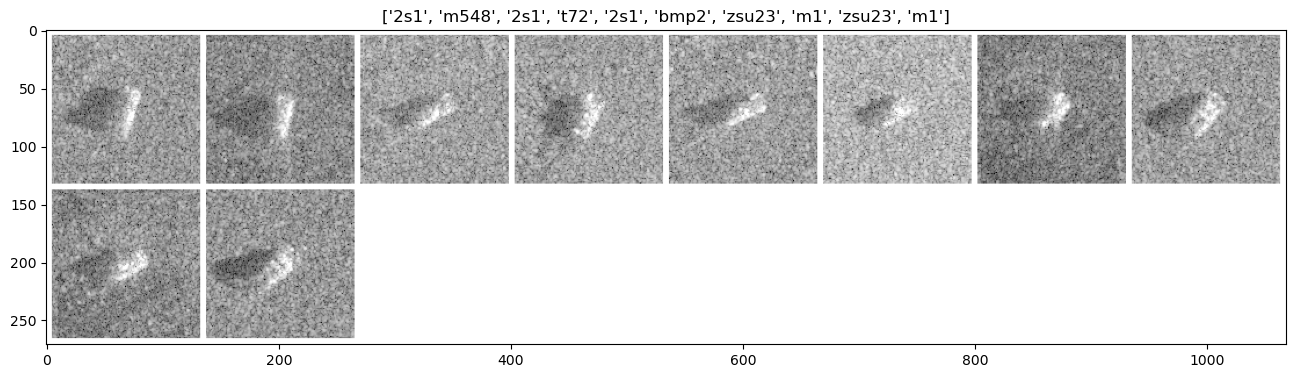

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


Synthetic


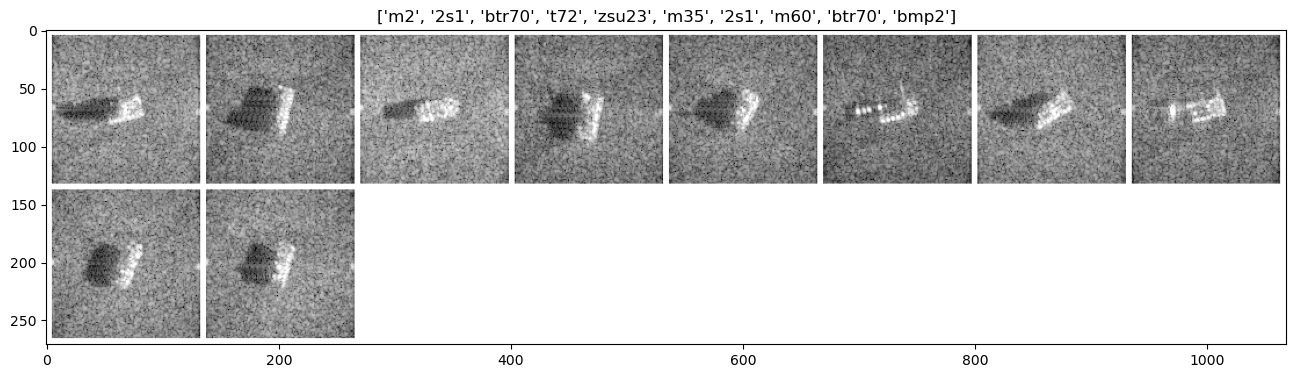

In [4]:
set_seed()

synthetic_data, measured_data = show_augmentations(
    color_jitter=False,
    gaussian_noise=False,
    random_erasing=False,
    jitter_params=None,
    noise_sigma=None,
    erasing_params=None
)

print('Measured')
measured_data_dataiter = iter(measured_data)
images, labels = next(measured_data_dataiter)
imshow(torchvision.utils.make_grid(images, padding=5, pad_value=5), [CLASSES[labels[j]] for j in range(len(labels))])

print('Synthetic')
synthetic_data_dataiter = iter(synthetic_data)
images, labels = next(synthetic_data_dataiter)
imshow(torchvision.utils.make_grid(images, padding=5, pad_value=5), [CLASSES[labels[j]] for j in range(len(labels))])

## Color Jitter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


Synthetic


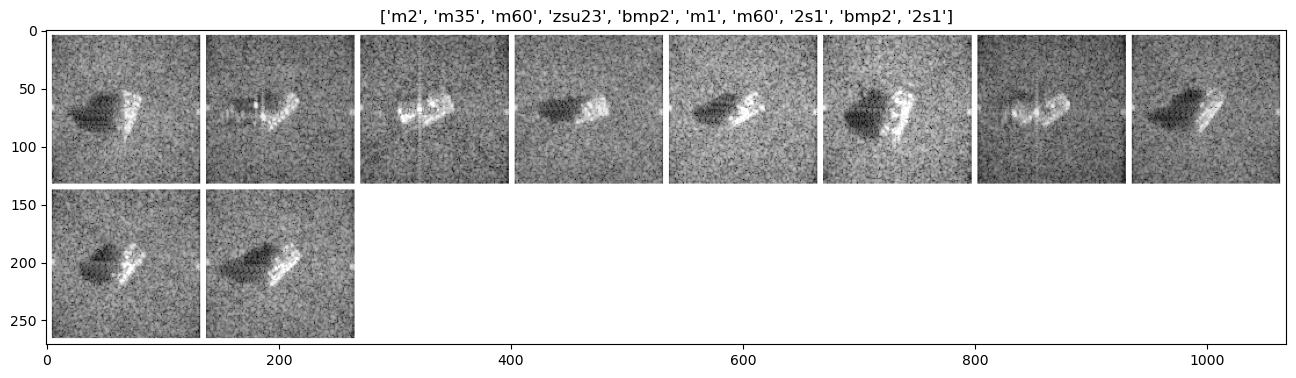

In [5]:
set_seed()

jitter_params = {
    "brightness": 0.1, 
    "hue": 0.5
}

synthetic_data, measured_data = show_augmentations(
    color_jitter=True,
    gaussian_noise=False,
    random_erasing=False,
    jitter_params=jitter_params,
    noise_sigma=None,
    erasing_params=None
)

print('Synthetic')
synthetic_data_dataiter = iter(synthetic_data)
images, labels = next(synthetic_data_dataiter)
imshow(torchvision.utils.make_grid(images, padding=5, pad_value=5), [CLASSES[labels[j]] for j in range(len(labels))])

## Gassian Noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4832537..3.0].


Synthetic


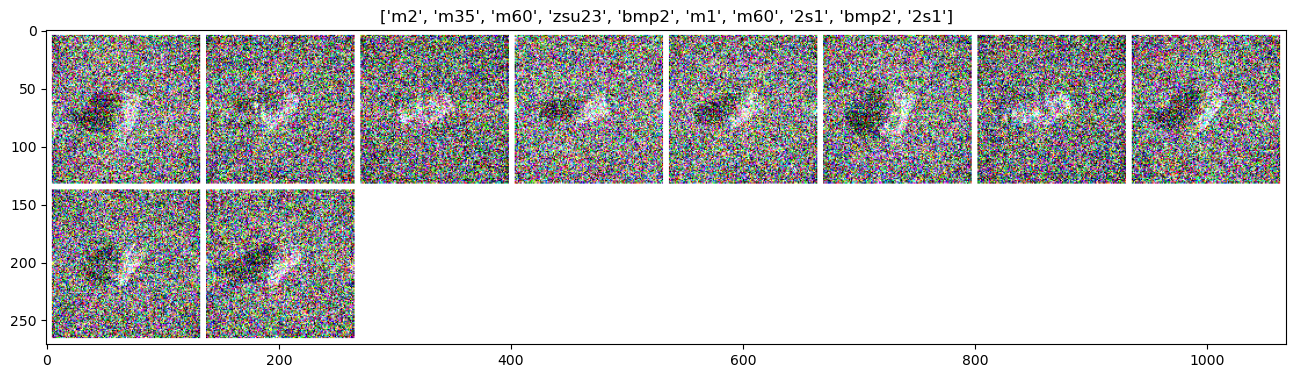

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


Measured


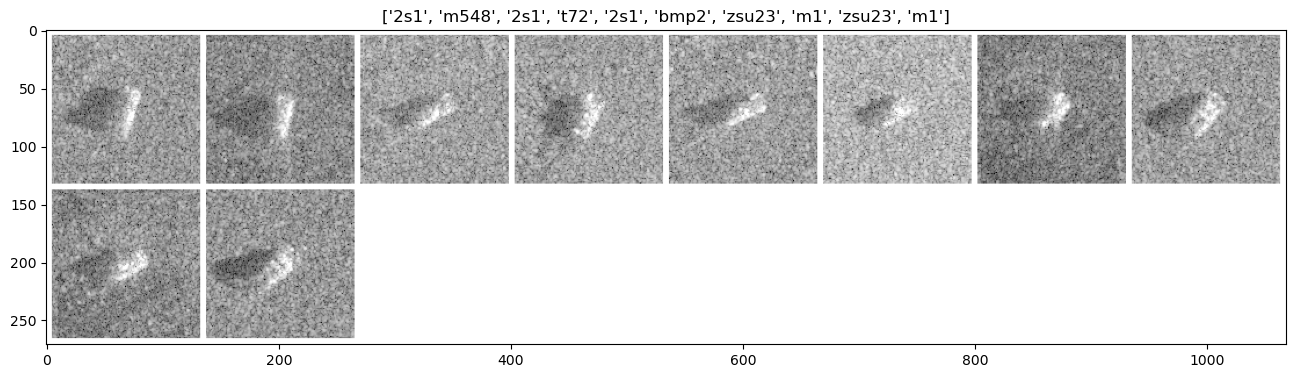

In [6]:
gaussian_noise = {"mean": 0.0, "sigma": 0.3}

synthetic_data, measured_data = show_augmentations(
    color_jitter=False,
    gaussian_noise=True,
    random_erasing=False,
    jitter_params=None,
    noise_sigma=0.4,
    erasing_params=None
)

print('Synthetic')
synthetic_data_dataiter = iter(synthetic_data)
images, labels = next(synthetic_data_dataiter)
imshow(torchvision.utils.make_grid(images, padding=5, pad_value=5), [CLASSES[labels[j]] for j in range(len(labels))])

print('Measured')
measured_data_dataiter = iter(measured_data)
images, labels = next(measured_data_dataiter)
imshow(torchvision.utils.make_grid(images, padding=5, pad_value=5), [CLASSES[labels[j]] for j in range(len(labels))])

## Random Erasing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


Synthetic


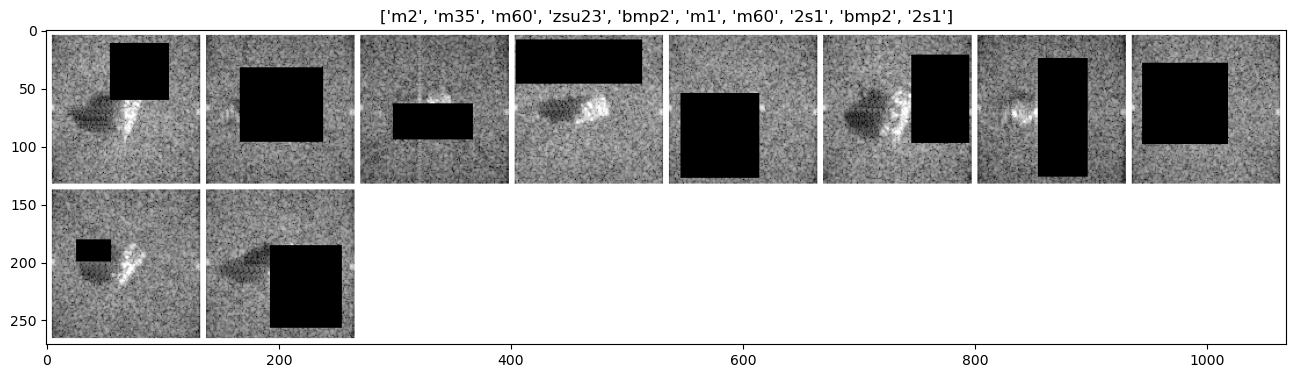

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


Measured


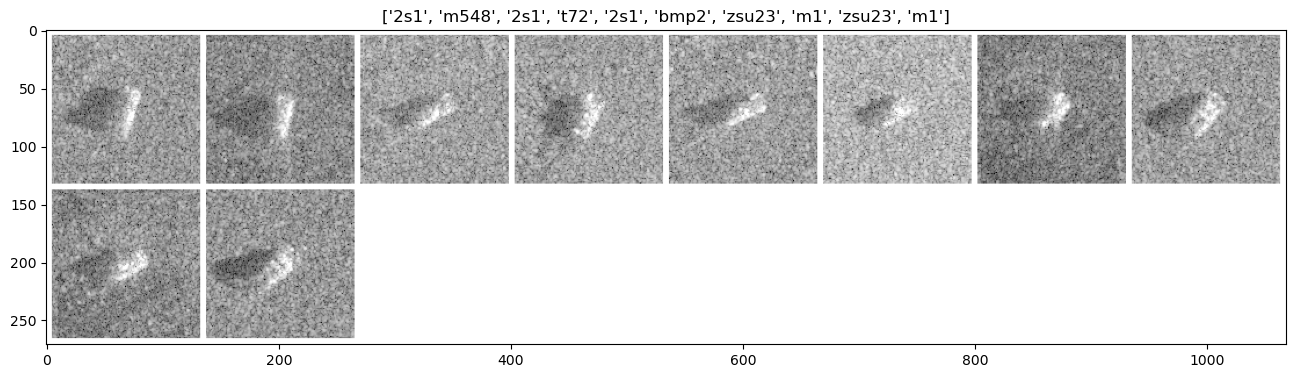

In [7]:
erasing_params = {
            "p": 1,
            "scale": (0.02, 0.33),
            "ratio": (0.3, 3.3),
            "value": 0,
        }

synthetic_data, measured_data = show_augmentations(
    color_jitter=False,
    gaussian_noise=False,
    random_erasing=True,
    jitter_params=None,
    noise_sigma=0,
    erasing_params=erasing_params
)

print('Synthetic')
synthetic_data_dataiter = iter(synthetic_data)
images, labels = next(synthetic_data_dataiter)
imshow(torchvision.utils.make_grid(images, padding=5, pad_value=5), [CLASSES[labels[j]] for j in range(len(labels))])

print('Measured')
measured_data_dataiter = iter(measured_data)
images, labels = next(measured_data_dataiter)
imshow(torchvision.utils.make_grid(images, padding=5, pad_value=5), [CLASSES[labels[j]] for j in range(len(labels))])

## Color Jitter and Gaussian Noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3496766..3.0].


Synthetic


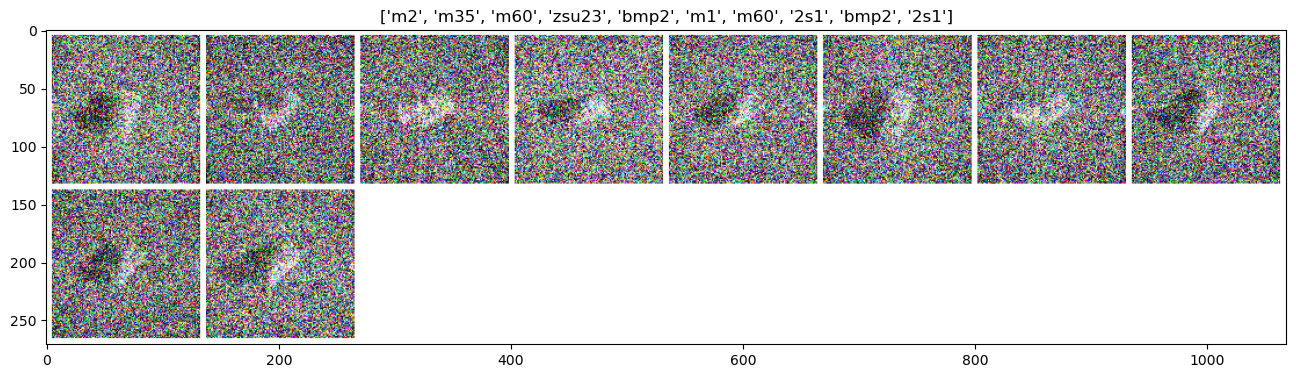

In [8]:
jitter_params = {
            "brightness": 0.1,
            # "contrast": 0.5,
            # "saturation": 0.5,
            "hue": 0.5,
        }
gaussian_noise = {"mean": 0.0, "sigma": 0.1}

synthetic_data, measured_data = show_augmentations(
    color_jitter=True,
    gaussian_noise=True,
    random_erasing=False,
    jitter_params=jitter_params,
    noise_sigma=0.4,
    erasing_params=None
)

print('Synthetic')
synthetic_data_dataiter = iter(synthetic_data)
images, labels = next(synthetic_data_dataiter)
imshow(torchvision.utils.make_grid(images, padding=5, pad_value=5), [CLASSES[labels[j]] for j in range(len(labels))])

## Color Jitter and Random Erasing

Synthetic


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


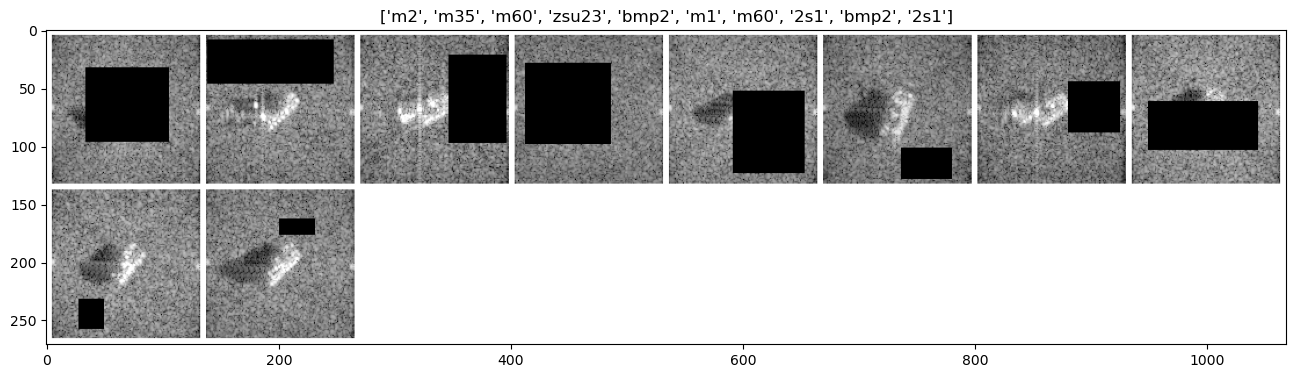

In [9]:
jitter_params = {
            "brightness": 0.1,
            # "contrast": 0.5,
            # "saturation": 0.5,
            "hue": 0.3,
        }
erasing_params = {
            "p": 1,
            "scale": (0.02, 0.33),
            "ratio": (0.3, 3.3),
            "value": 0,
        }

synthetic_data, measured_data = show_augmentations(
    color_jitter=True,
    gaussian_noise=False,
    random_erasing=True,
    jitter_params=jitter_params,
    noise_sigma=0.4,
    erasing_params=erasing_params
)

print('Synthetic')
synthetic_data_dataiter = iter(synthetic_data)
images, labels = next(synthetic_data_dataiter)
imshow(torchvision.utils.make_grid(images, padding=5, pad_value=5), [CLASSES[labels[j]] for j in range(len(labels))])

## Gaussian Noise and Random Erasing

Synthetic


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4832537..3.0].


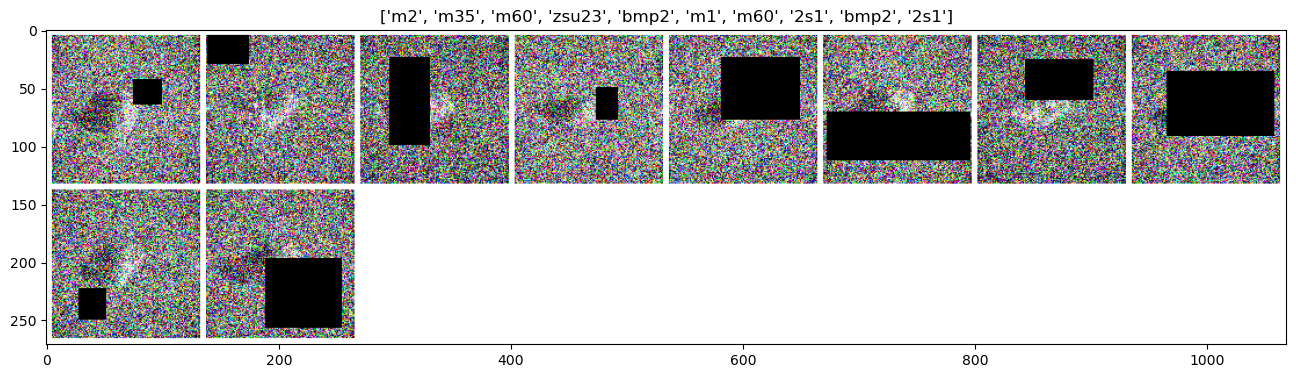

In [10]:
gaussian_noise = {"mean": 0.0, "sigma": 0.1}
erasing_params = {
            "p": 1,
            "scale": (0.02, 0.33),
            "ratio": (0.3, 3.3),
            "value": 0,
        }

synthetic_data, measured_data = show_augmentations(
    color_jitter=False,
    gaussian_noise=True,
    random_erasing=True,
    jitter_params=None,
    noise_sigma=0.4,
    erasing_params=erasing_params
)

print('Synthetic')
synthetic_data_dataiter = iter(synthetic_data)
images, labels = next(synthetic_data_dataiter)
imshow(torchvision.utils.make_grid(images, padding=5, pad_value=5), [CLASSES[labels[j]] for j in range(len(labels))])

## Color Jitter, Gaussian Noise, and Random Erasing

Synthetic


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.348422..3.0].


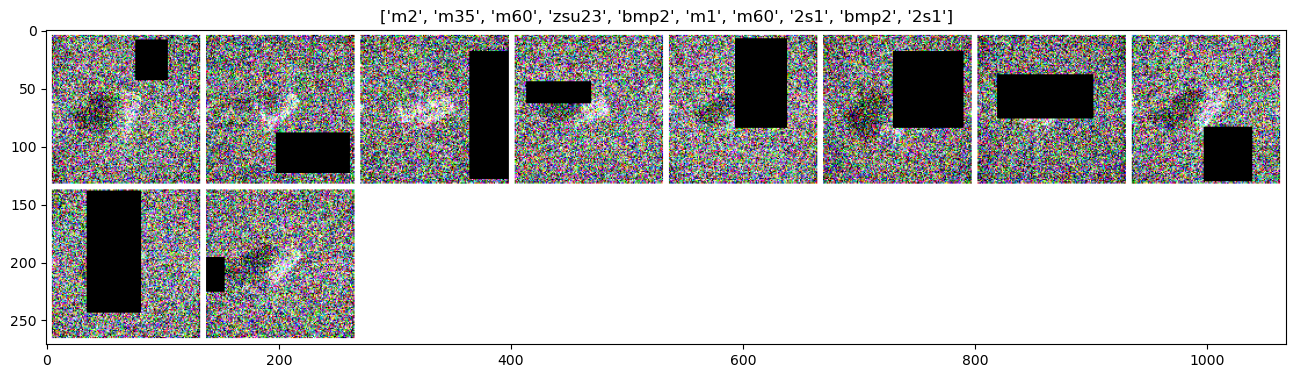

In [11]:
jitter_params = {
            "brightness": 0.1,
            # "contrast": 0.5,
            # "saturation": 0.5,
            "hue": 0.3,
        }
gaussian_noise = {"mean": 0.0, "sigma": 0.1}
erasing_params = {
            "p": 1.0,
            "scale": (0.02, 0.33),
            "ratio": (0.3, 3.3),
            "value": 0,
        }

synthetic_data, measured_data = show_augmentations(
    color_jitter=True,
    gaussian_noise=True,
    random_erasing=True,
    jitter_params=jitter_params,
    noise_sigma=0.4,
    erasing_params=erasing_params
)

print('Synthetic')
synthetic_data_dataiter = iter(synthetic_data)
images, labels = next(synthetic_data_dataiter)
imshow(torchvision.utils.make_grid(images, padding=5, pad_value=5), [CLASSES[labels[j]] for j in range(len(labels))])

## Heatmap visualization

1


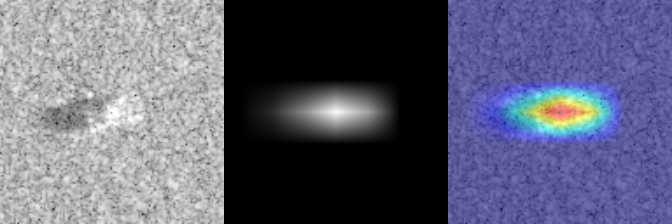

2


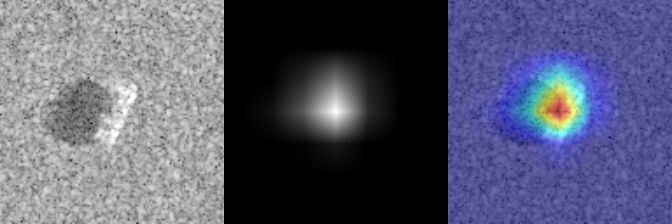

3


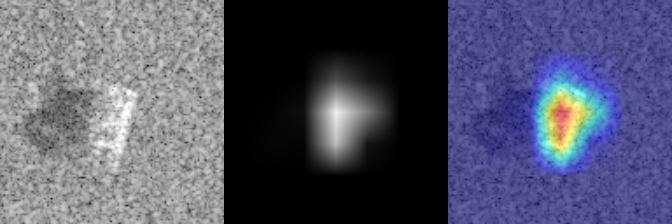

4


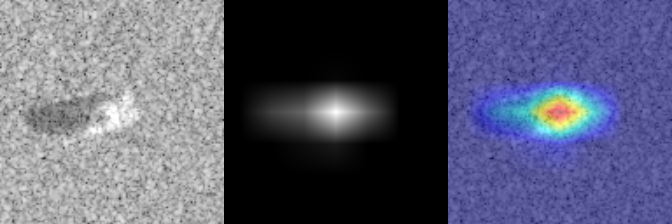

5


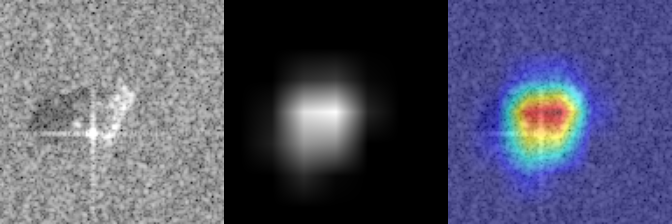

6


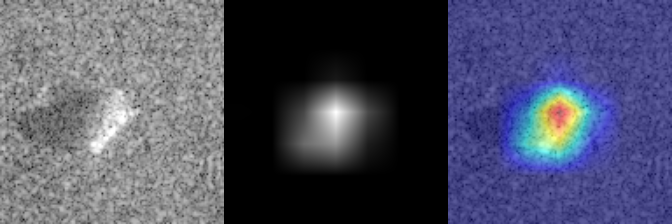

7


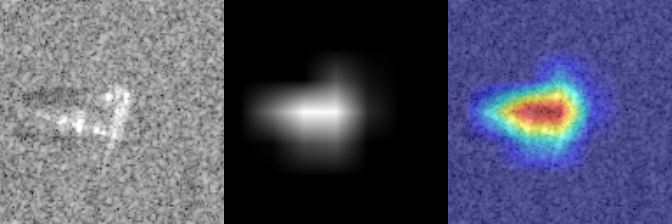

9


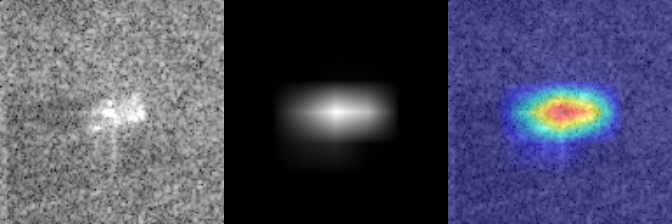

9


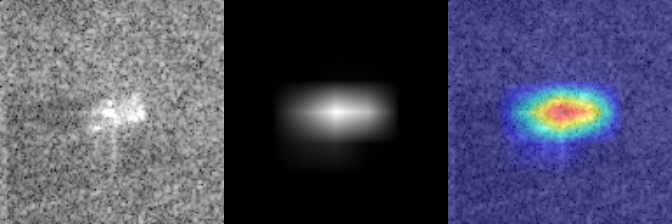

In [12]:
import matplotlib.image



methods = {
        "gradcam": GradCAM,
        "hirescam": HiResCAM,
        "scorecam": ScoreCAM,
        "gradcam++": GradCAMPlusPlus,
        "ablationcam": AblationCAM,
        "xgradcam": XGradCAM,
        "eigencam": EigenCAM,
        "eigengradcam": EigenGradCAM,
        "layercam": LayerCAM,
        "fullgrad": FullGrad,
        "gradcamelementwise": GradCAMElementWise,
        'kpcacam': KPCA_CAM
    }

method_list = ['eigengradcam',]

saved_model_dir = 'results/saved_model/best_model.pth'
model = Model(model_name='convnext_base')
model.load_state_dict(torch.load(saved_model_dir))
model.to(torch.device(device)).eval()

class_num_list = [1, 2, 3, 4, 5, 6, 7, 9, 9]
image_url = None
targets = [ClassifierOutputTarget(None)]

for class_num in class_num_list:
    if class_num==0: #2s1
        image_url = TEST_DIR + "/2s1/2s1_real_A_elevDeg_015_azCenter_010_22_serial_b01.PNG"
        targets = [ClassifierOutputTarget(class_num)]
    elif class_num==1: # bmp2
        image_url = TEST_DIR + "/bmp2/bmp2_real_A_elevDeg_016_azCenter_014_49_serial_9563.PNG"
        targets = [ClassifierOutputTarget(class_num)]
    elif class_num==2: # btr70
        image_url = TEST_DIR + "/btr70/btr70_real_A_elevDeg_017_azCenter_064_00_serial_c71.PNG"
        targets = [ClassifierOutputTarget(class_num)]
    elif class_num==3: # m1
        image_url = TEST_DIR + "/m1/m1_real_A_elevDeg_016_azCenter_077_18_serial_0ap00n.PNG"
        targets = [ClassifierOutputTarget(class_num)]
    elif class_num==4: # m2
        image_url = TEST_DIR + "/m2/m2_real_A_elevDeg_017_azCenter_017_91_serial_mv02gx.PNG"
        targets = [ClassifierOutputTarget(class_num)]
    elif class_num==5: # m35
        image_url = TEST_DIR + "/m35/m35_real_A_elevDeg_017_azCenter_059_62_serial_t839.PNG"
        targets = [ClassifierOutputTarget(class_num)]
    elif class_num==6: # m60
        image_url = TEST_DIR + "/m60/m60_real_A_elevDeg_016_azCenter_045_74_serial_3336.PNG"
        targets = [ClassifierOutputTarget(class_num)]
    elif class_num==7: # m548
        image_url = TEST_DIR + "/m548/m548_real_A_elevDeg_016_azCenter_071_63_serial_c245hab.PNG"
        targets = [ClassifierOutputTarget(class_num)]
    elif class_num==8: # t72
        image_url = TEST_DIR + "/t72/t72_real_A_elevDeg_017_azCenter_032_77_serial_812.PNG"
        targets = [ClassifierOutputTarget(class_num)]
    elif class_num==9: # zsu23
        image_url = TEST_DIR + "/zsu23/zsu23_real_A_elevDeg_017_azCenter_011_99_serial_d08.PNG"
        targets = [ClassifierOutputTarget(class_num)]
            
    img = cv2.imread(image_url)
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    input_tensor = input_tensor.to(device)
    
    target_layers = [model.model.features[7][-1]]
    
    for m in method_list:
        cam_algorithm = methods[m]
        with cam_algorithm(model=model, target_layers=target_layers) as cam:
            grayscale_cams = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True, eigen_smooth=True)
            cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True, image_weight=0.5, colormap=cv2.COLORMAP_JET)
        cam = np.uint8(255*grayscale_cams[0, :])
        cam = cv2.merge([cam, cam, cam])
        images = np.hstack((np.uint8(255*img), cam , cam_image))
        print(class_num)
        image = Image.fromarray(images)
        display(image)
        # Save the image
        image.save('results/gradcam/'+str(class_num)+'.png', quality=100) 
        # matplotlib.image.imsave(str(class_num+1)+'.png', Image.fromarray(images))

## Histogram of measured and synthetic SAR images

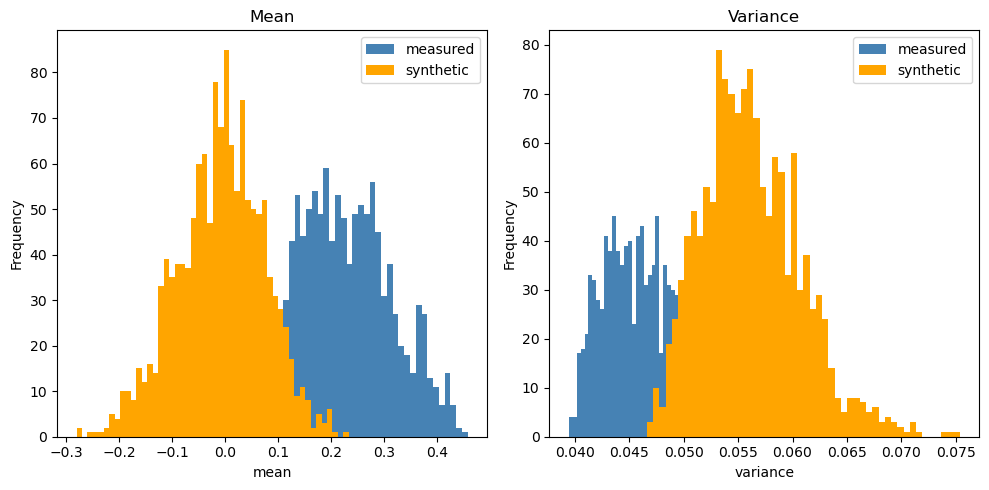

In [13]:
def compute_stats_per_image(data_loader):
    """
    Computes the average mean and variance for each image in the dataset.

    Args:
        data_loader (DataLoader): PyTorch DataLoader for the dataset.

    Returns:
        list: A list of dictionaries containing 'mean' and 'variance' for each image.
    """
    stats = []

    for images, _ in data_loader:
        for img in images:
            img_flat = img.view(img.size(0), -1)  # Flatten to (channels, -1)
            channel_mean = img_flat.mean(dim=1)
            channel_variance = img_flat.var(dim=1)

            avg_mean = channel_mean.mean().item()
            avg_variance = channel_variance.mean().item()

            stats.append({
                "mean": avg_mean,
                "variance": avg_variance
            })

    return stats

def plot_mean_variance_histograms(stats_real, stats_synth, bins=50, cumulative=False, histtype="bar", alpha=1):
    """
    Plots histograms comparing mean and variance of real and synthetic datasets.

    Args:
        stats_real (list): Mean and variance statistics for the real dataset.
        stats_synth (list): Mean and variance statistics for the synthetic dataset.
        bins (int): Number of bins for the histograms.
    """
    # Extract values
    means_real = [stat["mean"] for stat in stats_real]
    variances_real = [stat["variance"] for stat in stats_real]

    means_synth = [stat["mean"] for stat in stats_synth]
    variances_synth = [stat["variance"] for stat in stats_synth]

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Mean histogram
    axes[0].hist(means_real, bins=bins, color='steelblue', alpha=alpha, label='measured',  histtype=histtype, cumulative=cumulative)
    axes[0].hist(means_synth, bins=bins, color='orange', alpha=alpha, label='synthetic',  histtype=histtype, cumulative=cumulative)
    axes[0].set_title("Mean")
    axes[0].set_xlabel("mean")
    axes[0].set_ylabel("Frequency")
    axes[0].legend()

    # Variance histogram
    axes[1].hist(variances_real, bins=bins, color='steelblue', alpha=alpha, label='measured', histtype=histtype, cumulative=cumulative)
    axes[1].hist(variances_synth, bins=bins, color='orange', alpha=alpha, label='synthetic',  histtype=histtype, cumulative=cumulative)
    axes[1].set_title("Variance")
    axes[1].set_xlabel("variance")
    axes[1].set_ylabel("Frequency")
    axes[1].legend()

    plt.tight_layout()
    # plt.savefig('histogram_measured_synth.eps', format='eps')
    plt.show()

# color_jitter=color_jitter,
#             gaussian_noise=gaussian_noise,
#             random_erasing=random_erasing,
#             jitter_params=jitter_params,
#             noise_sigma=noise_sigma,
#             erasing_params=erasing_params
    
synthetic_data, measured_data = show_augmentations(
    color_jitter=False,
    gaussian_noise=False,
    random_erasing=False,
    jitter_params=None,
    noise_sigma=None,
    erasing_params=None
)

# Compute statistics
stats_real = compute_stats_per_image(measured_data)
stats_synth = compute_stats_per_image(synthetic_data)

# Plot histograms
plot_mean_variance_histograms(stats_real, stats_synth, bins=50)
